# 02 - Exploratory Data Analysis

In this notebook we will explore the data. Our goal is to predict whether or not the price of a flight will drop in the future to assist travelers in purchasing airline tickets. In this exploration of the data the plan is to try to understand the trends that flight prices follow over time and to discover the features that influence them.

1. Load data
2. Feature overview
3. Missing values
4. Feature Analysis
5. Price Over Time
6. Conclusions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from datetime import datetime

In [2]:
sns.set_context('notebook')
sns.set_palette('deep')
import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
flights = pd.read_csv('../data/interim/flights_interim.csv')
flights = flights.sample(2000000)
flights.shape

(2000000, 22)

In [4]:
flights.head()

,collectionDate,dDate,dTime,aDate,aTime,dTimeUTC,aTimeUTC,flyFrom,flyTo,airlines,...,distance,route,price,seats,cityFrom,cityCodeFrom,cityTo,cityCodeTo,countryFrom,countryTo
2091589,2021-03-24,2021-03-31,18:20,2021-04-01,13:55,2021-03-31 16:20:00,2021-04-01 17:55:00,MAD,JFK,"VY, LH",...,5767.20,MAD->BCN->FRA->JFK,295,3.0,Madrid,MAD,New York,NYC,Spain,United States
836050,2021-02-19,2021-05-03,10:20,2021-05-03,18:59,2021-05-03 08:20:00,2021-05-03 23:59:00,MAD,MEX,KL,...,9075.77,MAD -> MEX,343,NaN,Madrid,MAD,Mexico City,MEX,Spain,Mexico
1242188,2021-03-01,2021-04-26,16:20,2021-04-27,09:00,2021-04-26 14:20:00,2021-04-27 08:00:00,BCN,LGW,"UX, FR, VY",...,1110.28,BCN->OPO->MAD->LGW,74,8.0,Barcelona,BCN,London,LON,Spain,United Kingdom
1617513,2021-03-10,2021-04-23,18:20,2021-04-24,08:25,2021-04-23 16:20:00,2021-04-24 06:25:00,BCN,FCO,"LH, AZ",...,847.82,BCN->MUC->CDG->FCO,763,2.0,Barcelona,BCN,Rome,ROM,Spain,Italy
741974,2021-02-16,2021-02-20,15:35,2021-02-21,15:40,2021-02-20 14:35:00,2021-02-21 18:40:00,MAD,EZE,AF,...,10097.94,MAD -> EZE,797,7.0,Madrid,MAD,Buenos Aires,BUE,Spain,Argentina


In [5]:
# Data transformations needed for some visualization:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
flights['airline'] = flights['airlines'].apply(lambda x: x.split(',')[0])
flights['flight_no'] = flights['airline']+''+flights['flight_no'].astype(str)

### Features Overview

In [6]:
flights.columns

Index(['collectionDate', 'dDate', 'dTime', 'aDate', 'aTime', 'dTimeUTC',
       'aTimeUTC', 'flyFrom', 'flyTo', 'airlines', 'flight_no', 'fly_duration',
       'distance', 'route', 'price', 'seats', 'cityFrom', 'cityCodeFrom',
       'cityTo', 'cityCodeTo', 'countryFrom', 'countryTo', 'orig-dest',
       'airline'],
      dtype='object')

Features:
* **price**: airline ticket fare
* **collectionDate**: date flight data was taken
* **dDate**: departure day
* **dTime**: departure time
* **aDate**: arrival day
* **aTime**: arrival time
* **dTimeUTC**, **aTimeUTC**: departure and arrival time in UTC timezone
* **flyFrom**: origin airport IATA code
* **flyTo**: destination airport IATA code
* **airline**: self-explanatory
* **flight_no**: identification plain number
* **fly_duration**, **distance**: self-explanatory
* **route**: airports through the flight passes
* **seats**: availability
* **cityFrom**, **cityCodeFrom**, **cityTo**, **cityCodeTo**: different id's for the origin and destination cities
* **countryFrom**, **countryTo**: origin and dest countries

**Numerical**: distance, fly_duration, seats, price
\
**Categorical**: flyFrom, flyTo, airlines, route

Descriptive summary of the numerical features

In [7]:
flights[['distance', 'fly_duration', 'seats','price']].describe()

,distance,fly_duration,seats,price
count,2.000000e+06,2.000000e+06,1.571981e+06,2.000000e+06
mean,3.961320e+03,2.093429e+01,2.656741e+00,3.344369e+02
std,3.559364e+03,1.280891e+01,2.286220e+00,4.265415e+02
min,2.021800e+02,7.500000e-01,1.000000e+00,1.200000e+01
25%,1.110280e+03,1.216667e+01,1.000000e+00,1.060000e+02
50%,1.774110e+03,2.025000e+01,1.000000e+00,2.390000e+02
75%,5.767200e+03,2.775000e+01,3.000000e+00,3.920000e+02
max,1.009794e+04,6.000000e+01,8.000000e+00,7.540300e+04


### Missing Values

In [8]:
flights.isna().sum()

collectionDate         0
dDate                  0
dTime                  0
aDate                  0
aTime                  0
dTimeUTC               0
aTimeUTC               0
flyFrom                0
flyTo                  0
airlines               0
flight_no              0
fly_duration           0
distance               0
route                  0
price                  0
seats             428019
cityFrom               0
cityCodeFrom           0
cityTo                 0
cityCodeTo             0
countryFrom            0
countryTo              0
orig-dest              0
airline                0
dtype: int64

* 'seats' column has many missing values. Probably we will have to drop it.

## Feature Analysis

### Price

Price is one of the key features for our purpose. Let's start by looking at how it is distributed.

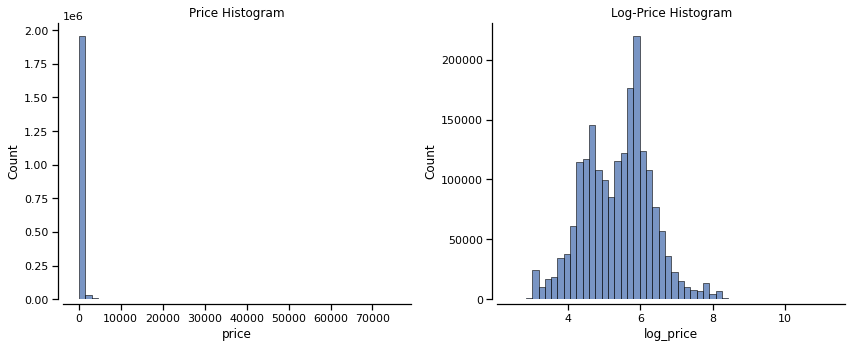

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=flights, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
flights['log_price'] = np.log(flights['price'])
sns.histplot(x='log_price', data=flights, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

* 'price' follows a exponential distribution and has many high values that skew to the right its distribution. 
* We have also plotted the price log-transformed.
* As we can see, 'log_price' aproximate a bit better to a normal distribution.

Let's see how price distribution changes according to the route:

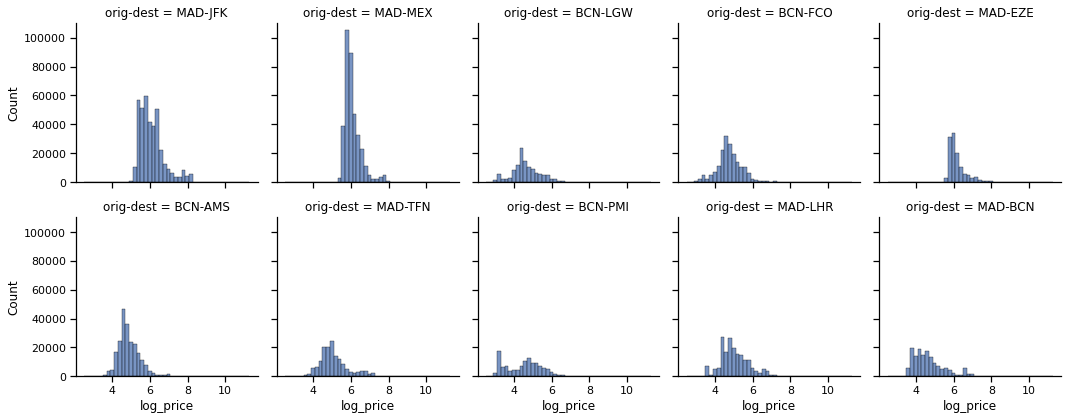

In [10]:
# Price distribution per route
sns.displot(
    flights, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

* As we can expect, some routes are more placed to the left (cheaper routes) and other to the right (more expensive routes).
* It seems that long-distance routes as 'MAD-MEX' (Madrid-Mexico) has narrower distribution than short-distance ones. 

And how does the price vary according to the route? Let's have a look

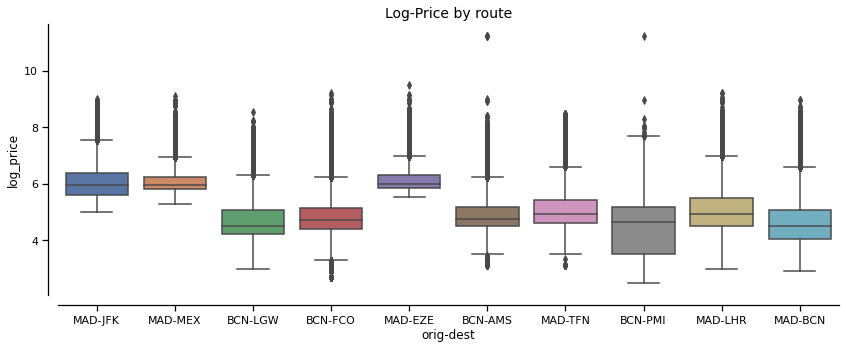

In [11]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='orig-dest', y='log_price', data=flights);
sns.despine(offset=10)
plt.title('Log-Price by route', fontsize=14);

* As expected, longest routes have more expensive fares
* Many outliers

### CollectionDate

This date feature represents the day that data was collected. 
\
We can use this variable to compute a new 'Days until departure' numerical variable using this column and departure date colunm.

In [12]:
flights['collectionDate'].head()

2091589    2021-03-24
836050     2021-02-19
1242188    2021-03-01
1617513    2021-03-10
741974     2021-02-16
Name: collectionDate, dtype: object

In [13]:
flights['collectionDate'].nunique(), flights['collectionDate'].min(), flights['collectionDate'].max()

(76, '2021-01-31', '2021-04-19')

* We have 76 days of data collected
* From Jan 31 to April 19

### FlyFrom, FlyTo

We have collected flights from 10 routes:

In [14]:
routes = flights['flyFrom'] +'-'+ flights['flyTo']

In [15]:
routes.unique()

array(['MAD-JFK', 'MAD-MEX', 'BCN-LGW', 'BCN-FCO', 'MAD-EZE', 'BCN-AMS',
       'MAD-TFN', 'BCN-PMI', 'MAD-LHR', 'MAD-BCN'], dtype=object)

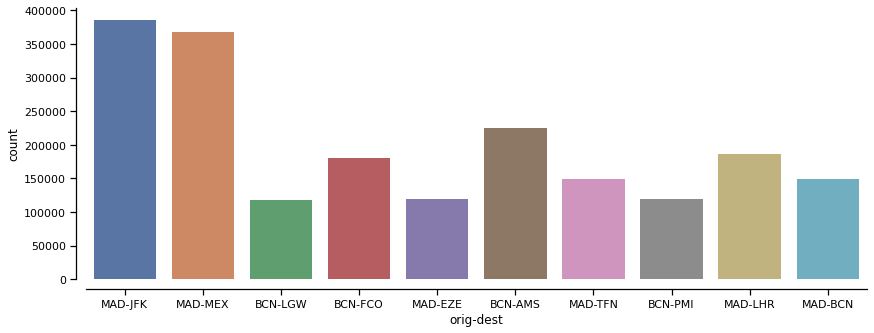

In [16]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=flights)
sns.despine(offset=10);
plt.xticks(rotation=0);

* MAD-JFK (Madrid-New York) and MAD-MEX (Madrid-Mexico City) are the busiest routes. The rest of them have a similar traffic.

### Airlines

In [17]:
flights[['airlines', 'route']].head()

,airlines,route
2091589,"VY, LH",MAD->BCN->FRA->JFK
836050,KL,MAD -> MEX
1242188,"UX, FR, VY",BCN->OPO->MAD->LGW
1617513,"LH, AZ",BCN->MUC->CDG->FCO
741974,AF,MAD -> EZE


* Airlines column show the carrier that manage a given flight. Hopping flights have more than one airline if there are diferent airlines in the itinerary.

In [18]:
flights['airline'].nunique()

153

There are 131 airlines in our dataset. Let's plot the top 40 busiest airline.

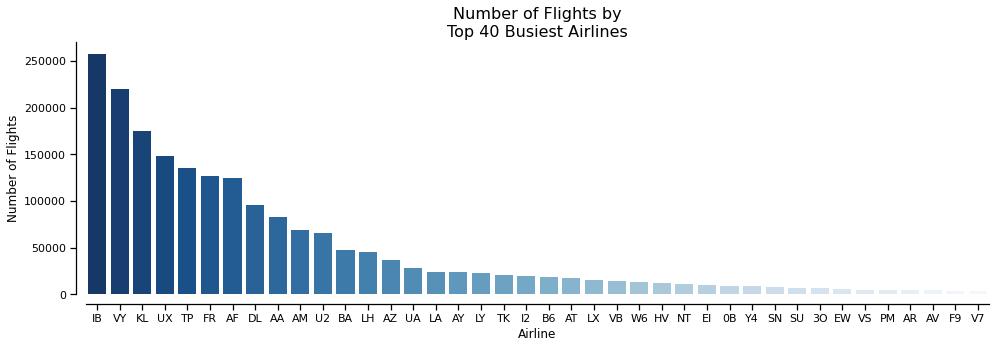

In [19]:
airlines_counts = flights.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

* Iberia (IB) is the airline with more flights in our dataset. Follow by Vueling (VY), KLM (KL), Air Europa (UX) and TAP Air Portugal (TP)

In [20]:
n_airlines = flights.groupby('orig-dest')['airline'].nunique().sort_values(ascending=False).reset_index()
n_airlines

,orig-dest,airline
0,MAD-JFK,98
1,MAD-MEX,98
2,MAD-LHR,86
3,MAD-BCN,85
4,BCN-FCO,78
5,BCN-AMS,75
6,BCN-LGW,74
7,BCN-PMI,65
8,MAD-EZE,65
9,MAD-TFN,65


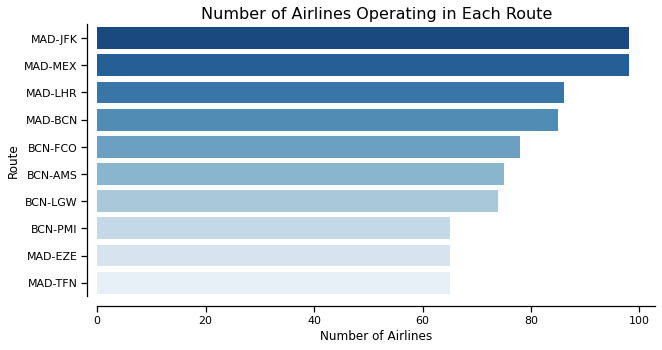

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='airline', y='orig-dest', data=n_airlines, palette='Blues_r');
plt.title('Number of Airlines Operating in Each Route', fontsize=16)
plt.xlabel('Number of Airlines');
plt.ylabel('Route')
sns.despine(offset=10)

* MAD-MEX and MAD-JFK are the routes with the largest number of different airlines operating on them.
* In general, more airlines operate on international routes.

### Flight_no

In [22]:
flights['flight_no'].head()

2091589    VY1007
836050     KL1700
1242188    UX8478
1617513    LH1817
741974     AF1601
Name: flight_no, dtype: object

* It seeams that 'flight_no' identifies a unique plain. 

In [23]:
flights.groupby('flight_no')['orig-dest'].nunique().sort_values(ascending=False).head(5)

flight_no
VY3920    10
VY3916    10
I23920     9
IB3914     9
FR3920     9
Name: orig-dest, dtype: int64

* There 'flight_no' values for more than one route. This means plains not always operates in the same itinerary.
* Probably we will drop this feature.

### Fly_duration

This feature represents the duration of the flight in hours.

In [24]:
flights['fly_duration'].head()

2091589    25.583333
836050     15.650000
1242188    17.666667
1617513    14.083333
741974     28.083333
Name: fly_duration, dtype: float64

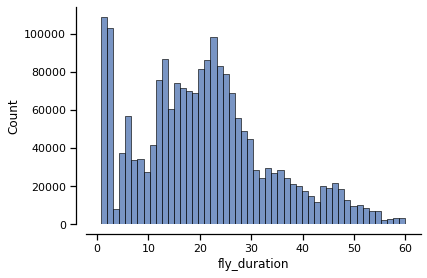

In [25]:
sns.histplot(flights['fly_duration'], bins=50);
sns.despine(offset=10)

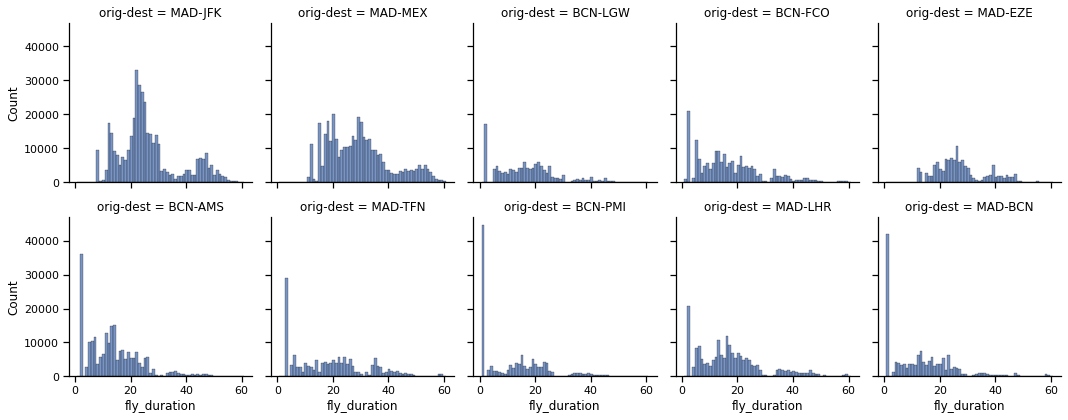

In [26]:
# fly_duration distribution for route
sns.displot(
    flights, x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

* It seems that there are variability in the fly_duration variable even in flights on the same route.
* We can notice that in some routes a considerable number of flights concentreates in some point on the left side. These are probable direct flights.

In [27]:
# Direct flights
flights['hops'] = flights['route'].apply(lambda x: len(x.split('->')) - 2)
flights['direct'] = flights['hops'] == 0

In [28]:
# There are observations with wrong column due an error during collection. We'll drop them.

split_date = datetime.strptime('2021-02-24', '%Y-%m-%d')
broken = pd.to_datetime(flights['collectionDate']) < split_date

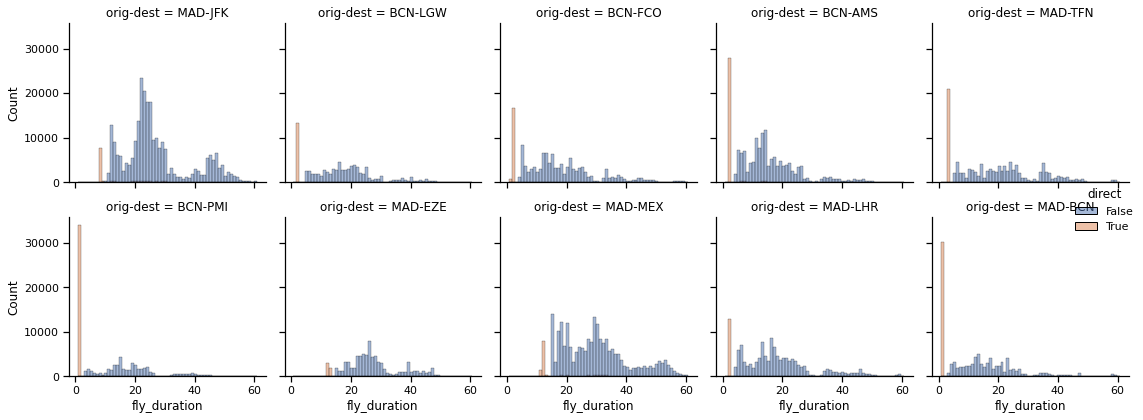

In [29]:
# Price distribution for route
g = sns.displot(
    flights[~broken], x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3, hue='direct', facet_kws={"legend_out": True}
);
plt.tight_layout()

* Now we can clearly distinguish between direct flights and flights with hopping in the fly_duration distributions now

### Distance

In [30]:
flights['distance'].unique()

array([ 5767.2 ,  9075.77,  1110.28,   847.82, 10097.94,  1242.46,
        1774.11,   202.18,  1245.76,   483.25])

* Distance is fixed for each route. It is the geographical distance between the two airports.

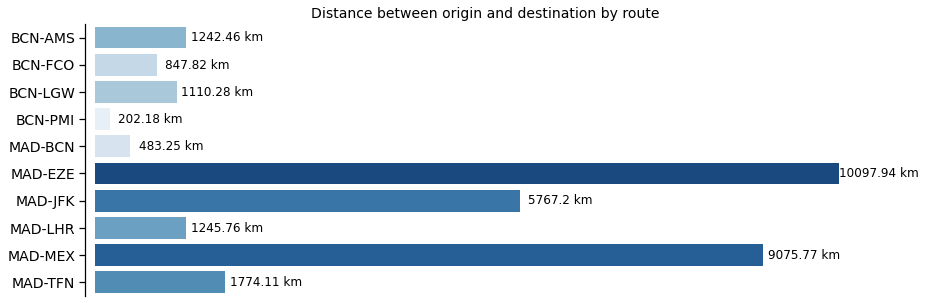

In [31]:
route_distances = flights.groupby('orig-dest')['distance'].mean().reset_index()
pal = sns.color_palette("Blues_r", len(route_distances))
rank = route_distances["distance"].argsort().argsort() 

plt.figure(figsize=(14,5))
g = sns.barplot(y='orig-dest', x='distance', data=route_distances, palette=np.array(pal[::-1])[rank]);

# values text
for index, row in route_distances.iterrows():
    g.text(row['distance']+550, index+0.13, str(round(row['distance'],2))+' km' , color='black', ha="center")

plt.title('Distance between origin and destination by route', fontsize=14)
sns.despine(offset=10, bottom=True)

# remove x axis
plt.xticks([])
plt.xlabel(None)
plt.ylabel(None)

# scale y ticks
plt.yticks(fontsize=14);

### Route

In [32]:
flights['route']

2091589         MAD->BCN->FRA->JFK
836050                  MAD -> MEX
1242188         BCN->OPO->MAD->LGW
1617513         BCN->MUC->CDG->FCO
741974                  MAD -> EZE
                    ...           
570541                  MAD -> MEX
865034                  MAD -> JFK
2045800    MAD->BCN->LIS->BOS->JFK
1875209    MAD->PMI->BIO->FRA->JFK
353120                  MAD -> EZE
Name: route, Length: 2000000, dtype: object

* This variable shows the hops in a flight route between origin and destination
* We can use this to create a new columns that computes the number of hops

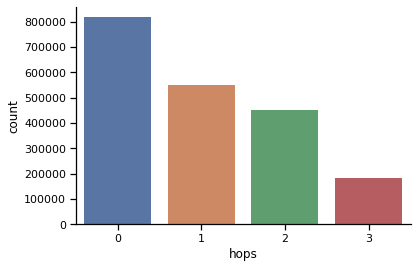

In [33]:
sns.countplot(flights['hops']);
sns.despine(trim=False, offset=0)

Most of the flights are direct. Are direct flights cheaper?

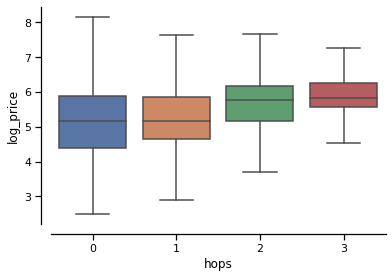

In [34]:
sns.boxplot(x='hops', y='log_price', data=flights, showfliers=False);
sns.despine(offset=10)

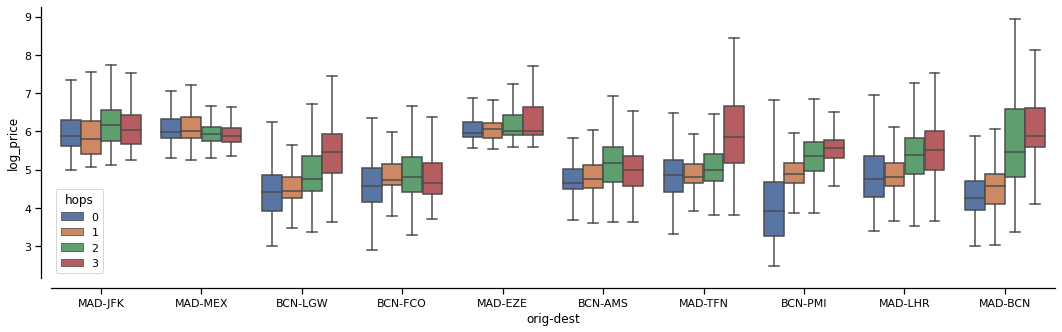

In [35]:
plt.figure(figsize=(18,5))
sns.boxplot(x='orig-dest', y='log_price', data=flights, hue='hops', showfliers=False);
sns.despine(offset=10)

* It seems that it is. In general, direct flights are the cheapest.
* The difference between direct and non-direct is greater in short-distance route as 'BCN-PMI' or 'MAD-BCN'
* In long distance routes this difference is smaller. Even in one route ('MAD-MEX') direct flights are a bit expensive than flights with 2 or more stops.

### Seats

Available seats in the flight? It is not clear what means this variable. Moreover, it has many drop values so it is a great candidate to drop it.

In [36]:
flights['seats'].isna().sum()

428019

In [37]:
flights['seats'].isna().sum() / flights.shape[0]

0.2140095

* This column has many NaN values (21.19%)

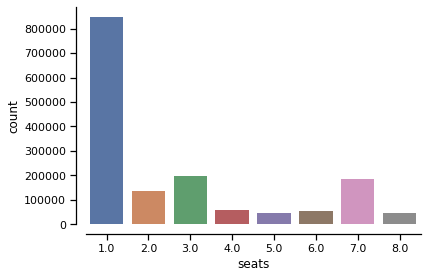

In [38]:
sns.countplot(flights['seats']);
sns.despine(offset=10)

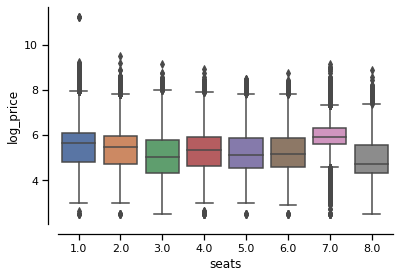

In [39]:
sns.boxplot(x='seats', y='log_price', data=flights);
sns.despine(offset=10)

* There does not appear to be any correlation between seats and price. Except for value 7 which seems to have a slightly higher price.

## Price over time

Now that we have taken a look at each of the relevant features of the dataset, let's focus on the main objective of this project. Let's see how the price evolves over time until the day of departure of the flight.
\
We use the first quantile when aggregating data, since we are more interested in low flights fares.

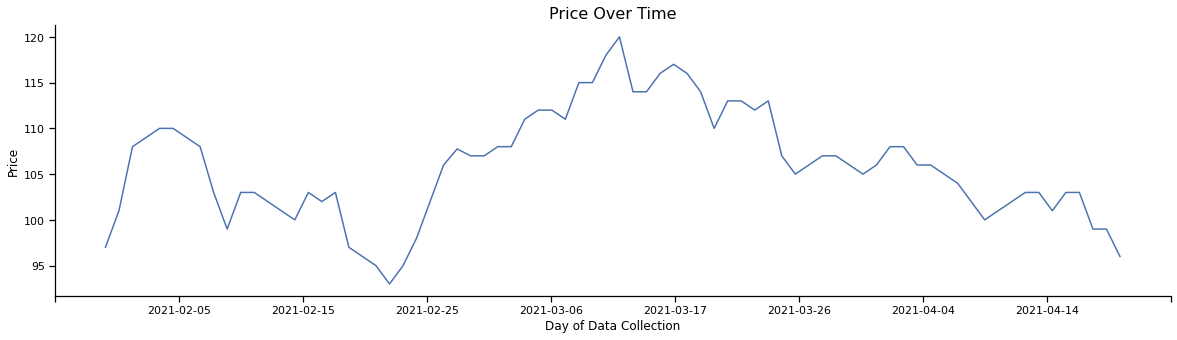

In [40]:
grouped = flights.groupby('collectionDate')['price'].quantile(.25).reset_index()

plt.figure(figsize=(20,5))
f = sns.lineplot(x='collectionDate', y='price', data=grouped);
f.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=0);
sns.despine(offset=0)
plt.xlabel('Day of Data Collection');
plt.ylabel('Price')
plt.title('Price Over Time', fontsize=16);

* As the graph shows, prices rise throughout the month of March and are higher than during April or February. 
* Price decreases seems occur at the end of the month. As we do not have more data we cannot conclude if this is an isolated case (COVID third wave in March) or happens more often throughout the year.

Now let's see how price evolves by route:

<Figure size 1008x576 with 0 Axes>

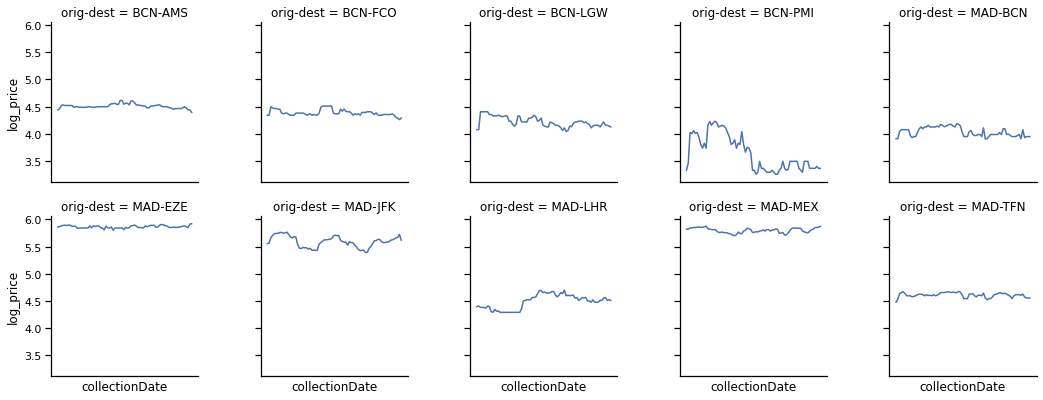

In [41]:
grouped = flights.groupby(['orig-dest','collectionDate'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5);
g.map(sns.lineplot, "collectionDate", "log_price");
plt.xticks([]);

* There are quite a few routes where the price does not vary so much.
* Route MAD-JFK appears to have some degree of seasonality. We cannot confirm this with so little data
* Route BCN-PMI has a steep drop in price during March.

We can't use 'collectionDate' as a feature since we want to make prediction with new days. So let's create a new numeric variable called 'days_until_dep' to group the flights according to how many days left before the departure of the flight. This way we can see how the price changes with time.

In [42]:
def add_days_until_dep_feature(df):
    """ Remaining days until flight departure """
    collected = pd.to_datetime(df['collectionDate'])
    departure =  pd.to_datetime(df['dDate'])
    daysUntilDep = departure - collected
    df['days_until_dep'] = daysUntilDep.dt.days
    return df

In [43]:
flights = add_days_until_dep_feature(flights)

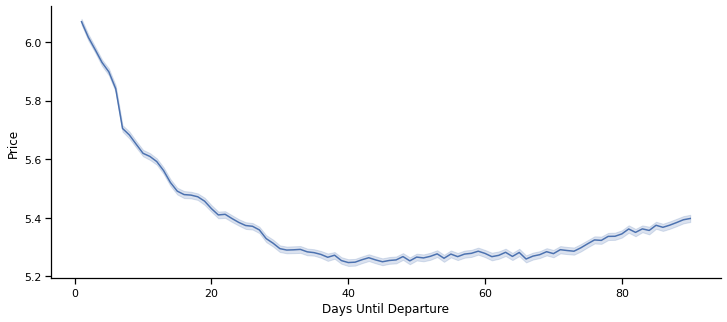

In [241]:
plt.figure(figsize=(12,5))
sns.lineplot(x='days_until_dep', y='log_price', data=flights);
sns.despine(offset=0);
plt.ylabel('Price')
plt.xlabel('Days Until Departure');

* Generally the price decreases until around 50 days until departure and then start increasing.

Now we will try to group the data using different features to find which ones affect the flight price trend the most.

### Route

<Figure size 1008x576 with 0 Axes>

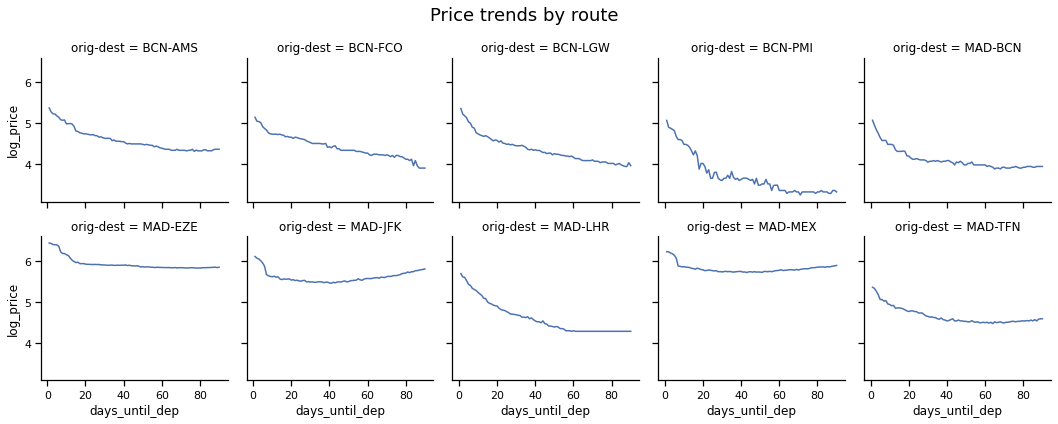

In [45]:
grouped = flights.groupby(['orig-dest','days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5);
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by route', fontsize=18);
plt.tight_layout()

* The 'orig-dest' feature is one of the features that most affects the price of a flight as well as the trend it follows. Also since we only have 10 different routes it is one of the main categories we will use to aggregate the flights.

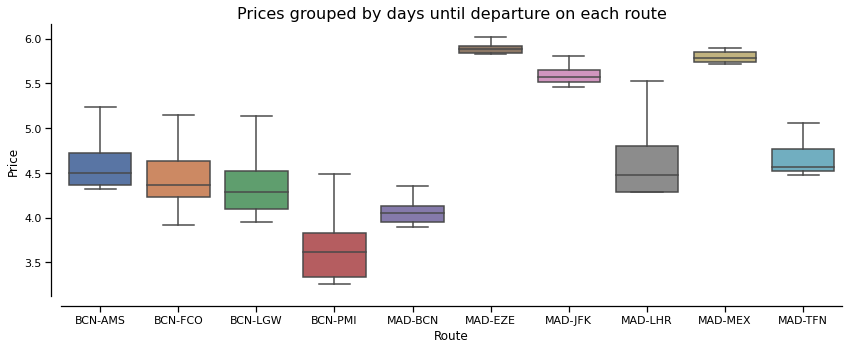

In [46]:
plt.figure(figsize=(14,5));
sns.boxplot(x='orig-dest', y='log_price', data=grouped, showfliers=False);
sns.despine(offset=10);
plt.ylabel('Price')
plt.xlabel('Route');
plt.title('Prices grouped by days until departure on each route', fontsize=16);

* Price variance is not uniform through all routes. So maybe we can expect that the model will generate more savings (percentage) on one route than another since the greater the price difference, the more room for the price to go down.

### Airline

There 152 airlines in our dataset so let's just plot top 10 most frequent airlines from all the flights.

<Figure size 1008x576 with 0 Axes>

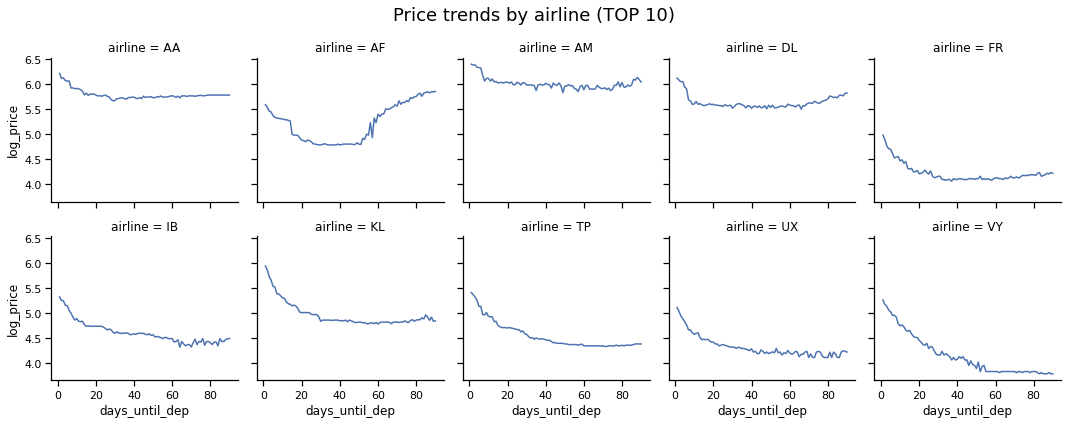

In [47]:
top10_airlines = flights.groupby(['airline'])['price'].count().sort_values(ascending=False)[:10].index
top10_flights = flights[flights['airline'].isin(top10_airlines)]
grouped = top10_flights.groupby(['airline','days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="airline", col_wrap=5);
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by airline (TOP 10)', fontsize=18);
plt.tight_layout()

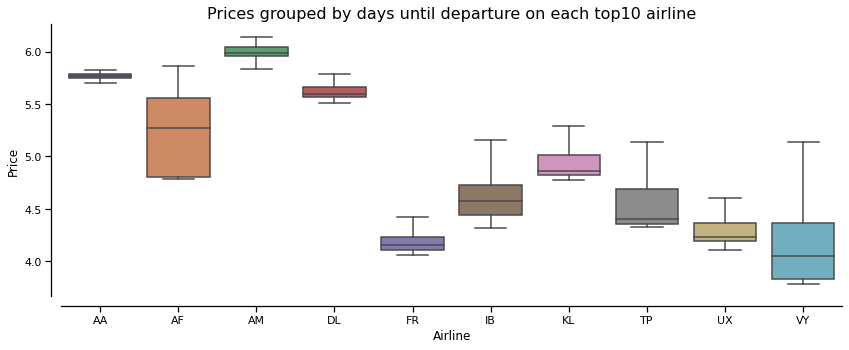

In [48]:
plt.figure(figsize=(14,5));
sns.boxplot(x='airline', y='log_price', data=grouped, showfliers=False);
sns.despine(offset=10);
plt.ylabel('Price')
plt.xlabel('Airline');
plt.title('Prices grouped by days until departure on each top10 airline', fontsize=16);

* Similar to 'orig-dest', there are many differences on how vary prices as the days go by until the departure of the flight.

Now we combine both 'orig-dest' and 'airline'

<Figure size 1008x576 with 0 Axes>

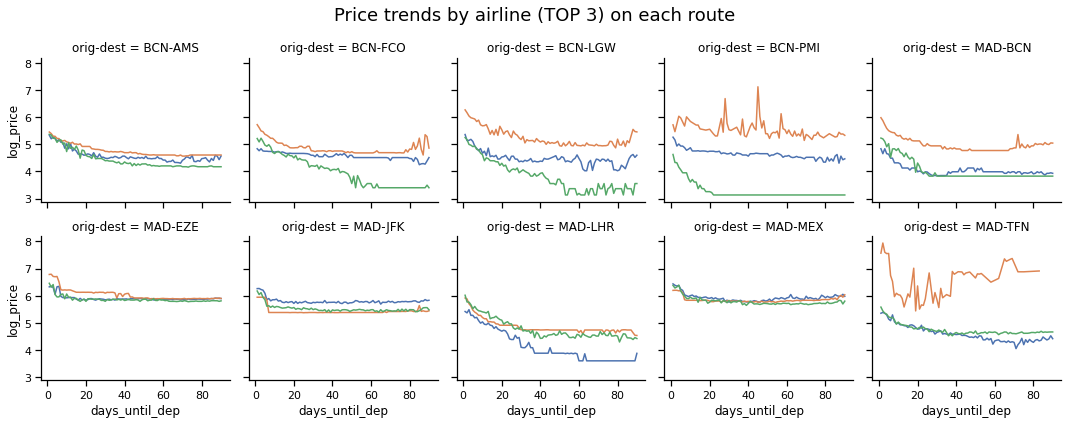

In [217]:
top3_airlines = flights.groupby(['airline'])['price'].count().sort_values(ascending=False)[:3].index
top3_flights = flights[flights['airline'].isin(top3_airlines)]
grouped = top3_flights.groupby(['orig-dest', 'airline','days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5, hue='airline');
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by airline (TOP 3) on each route', fontsize=18);
plt.tight_layout()

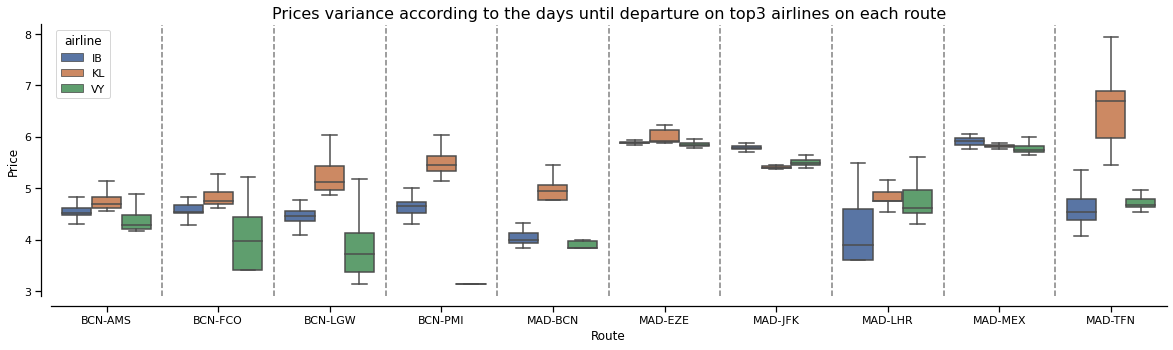

In [219]:
plt.figure(figsize=(20,5));
sns.boxplot(x='orig-dest', y='log_price', data=grouped, showfliers=False, hue='airline');
sns.despine(offset=10);
plt.ylabel('Price')
plt.xlabel('Route');
plt.title('Prices variance according to the days until departure on top3 airlines on each route', fontsize=16);
[plt.axvline(x, color = 'grey', linestyle='--') for x in [0.5,1.5,2.5,3.5, 4.5,5.5, 6.5, 7.5,8.5]];


Even within each route the prices of each airline act differently. So it is a factor that we should take into account to predict whether the price will go down in the future. Since we have so many airlines we have to take into account that this will add many variables to the model.

### Adding new features

### Day of week

Day of the week of flight departure

In [231]:
## Create 'day_of_week' feature
days_of_week = {5:'Monday', 6:'Tuesday', 0:'Wednesday', 1:'Thursday', 2:'Friday', 3:'Saturday', 4:'Sunday'}
flights['day_of_week'] = pd.to_datetime(flights['dTime']).dt.weekday.map(days_of_week)

<Figure size 1008x576 with 0 Axes>

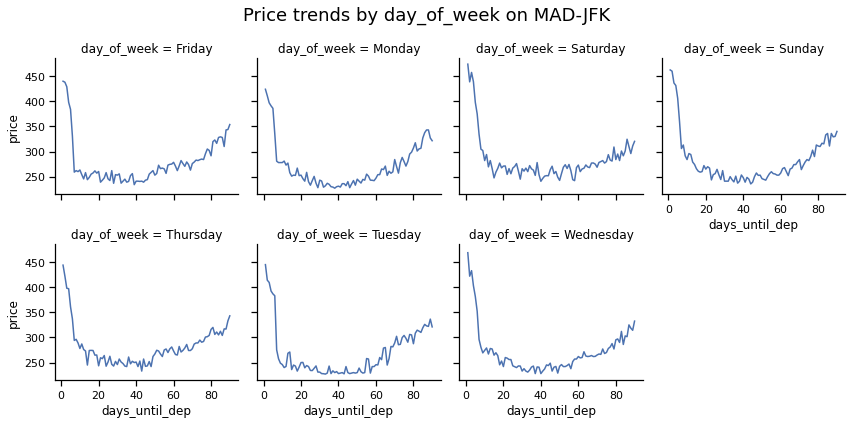

In [232]:
mad_ny = flights[flights['orig-dest'] == 'MAD-JFK']
grouped = mad_ny.groupby(['orig-dest', 'day_of_week', 'days_until_dep'])['price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="day_of_week", col_wrap=4);
g.map(sns.lineplot, "days_until_dep", "price");
g.fig.suptitle('Price trends by day_of_week on MAD-JFK', fontsize=18);
plt.tight_layout()


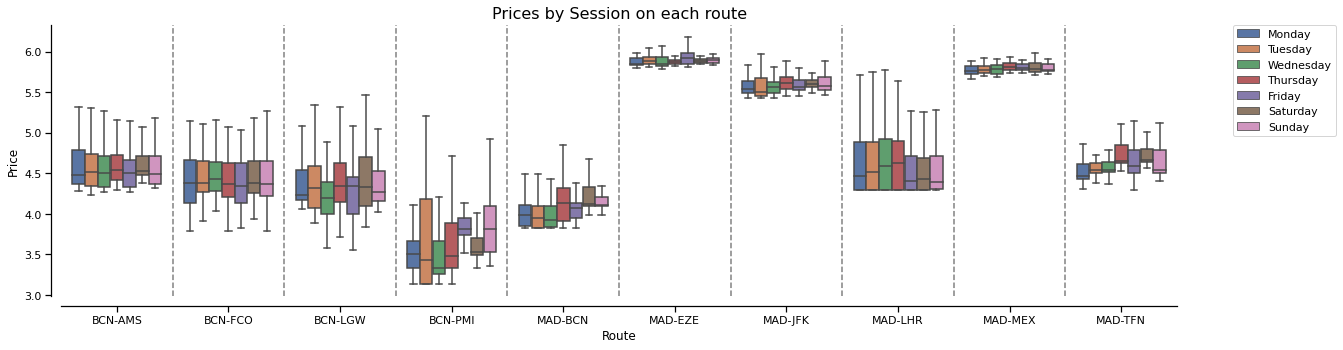

In [233]:
plt.figure(figsize=(20,5));
grouped = flights.groupby(['orig-dest', 'day_of_week', 'days_until_dep'])['log_price'].quantile(.25).reset_index()
sns.boxplot(x='orig-dest', y='log_price', data=grouped, showfliers=False, hue='day_of_week',
            hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
sns.despine(offset=10);
plt.ylabel('Price')
plt.xlabel('Route');
plt.title('Prices by Session on each route', fontsize=16);
[plt.axvline(x, color = 'grey', linestyle='--') for x in [0.5,1.5,2.5,3.5, 4.5,5.5, 6.5, 7.5,8.5]];
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

* It seems that day_of_week has less impact in price trend than airline and orig-dest

### Session

Time of the flight departure day categorized as 'morning', 'evening', 'night'

In [55]:
# create 'session' feature from dTime
flights['session'] = pd.cut(pd.to_datetime(flights['dTime']), bins=3, labels=['night', 'morning', 'evening'])

<Figure size 1008x576 with 0 Axes>

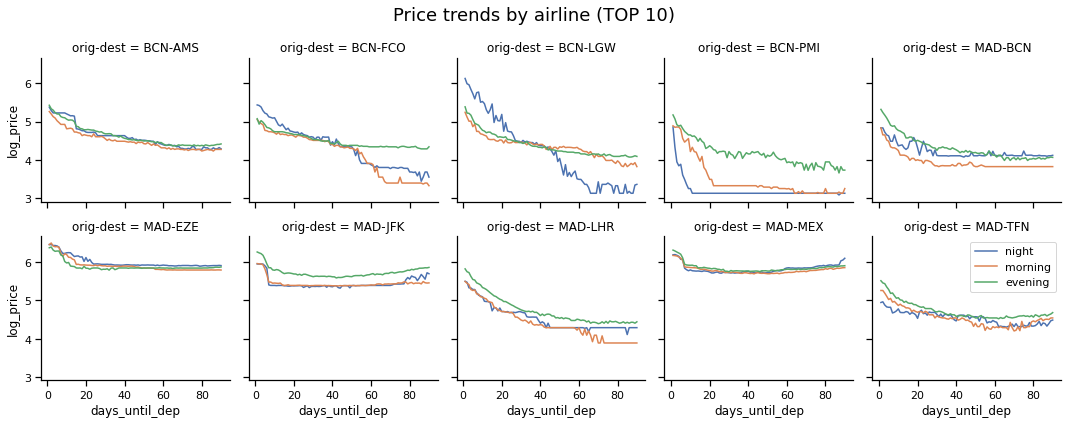

In [56]:
grouped = flights.groupby(['orig-dest', 'session', 'days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5, hue='session');
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by airline (TOP 10)', fontsize=18);
plt.tight_layout()
plt.legend();

* On some routes the session seems irrelevant to the price trend but on others differences are noticeable.

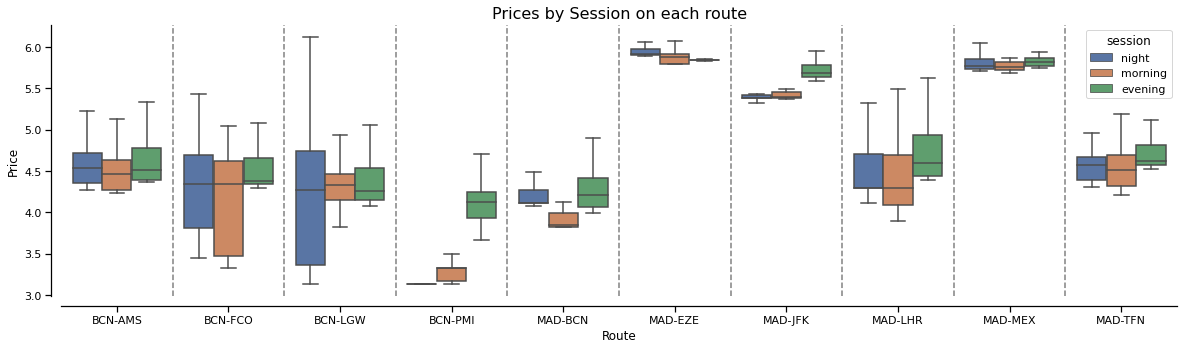

In [57]:
plt.figure(figsize=(20,5));
sns.boxplot(x='orig-dest', y='log_price', data=grouped, showfliers=False, hue='session');
sns.despine(offset=10);
plt.ylabel('Price')
plt.xlabel('Route');
plt.title('Prices by Session on each route', fontsize=16);
[plt.axvline(x, color = 'grey', linestyle='--') for x in [0.5,1.5,2.5,3.5, 4.5,5.5, 6.5, 7.5,8.5]];

* Prices are higher at evenings flights, less expensive at night, mornings flights are the cheapest
* Session seems a good candidate for aggregate data, also it has only three categories so we don't add much complexity to the model.

### Day of month

In [58]:
flights['day_of_month'] = pd.to_datetime(flights['dDate']).apply(lambda departure_date: departure_date.day)
flights['daymonth_bins'] = pd.cut(flights['day_of_month'], bins=4)

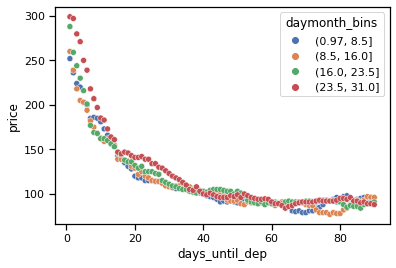

In [59]:
grouped = flights.groupby(['daymonth_bins', 'days_until_dep'])['price'].quantile(.25).reset_index()
sns.scatterplot(x='days_until_dep', y='price', data=grouped, hue='daymonth_bins');

<Figure size 1008x576 with 0 Axes>

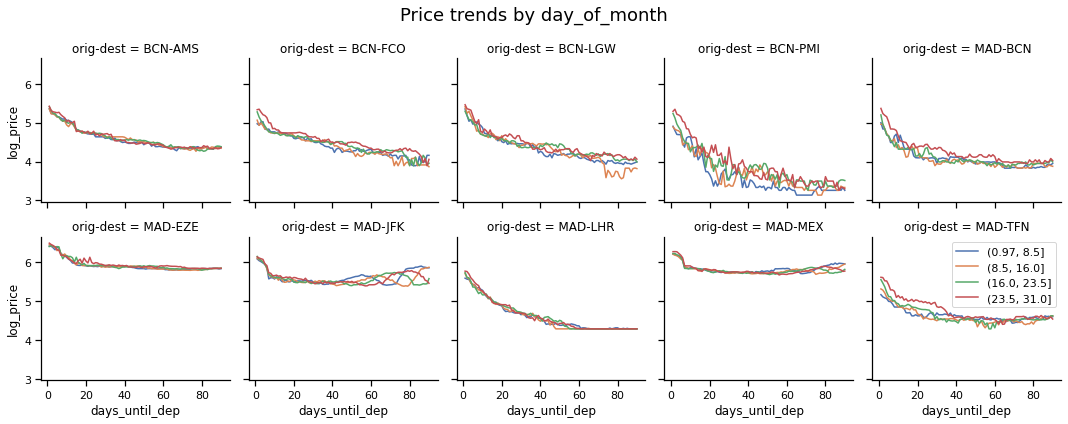

In [60]:
grouped = flights.groupby(['orig-dest', 'daymonth_bins', 'days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5, hue='daymonth_bins');
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by day_of_month', fontsize=18);
plt.tight_layout();
plt.legend();

* Day of month does not have impact on price trends. So we'll drop it.

## Preliminary features selected for agg. flights: 'orig-dest', 'airline', 'session', 'days_until_dep'

<Figure size 1008x576 with 0 Axes>

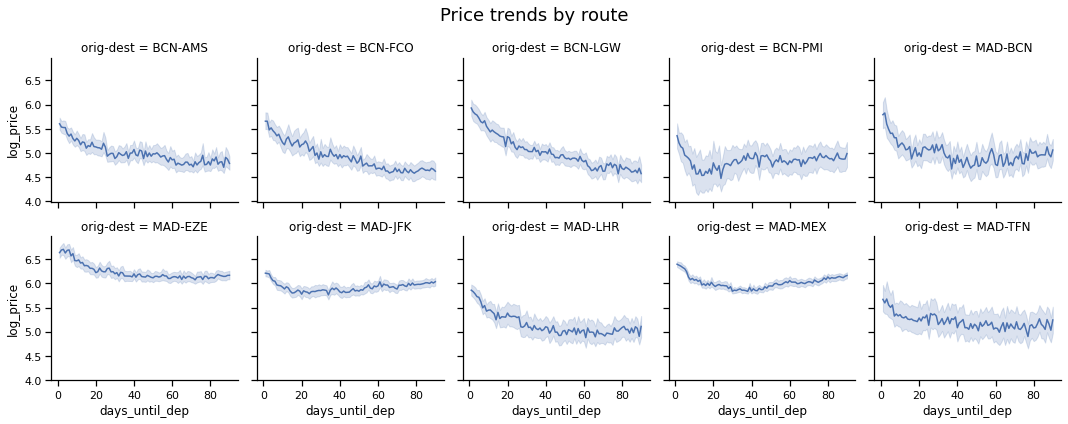

In [187]:
grouped = flights.groupby(['orig-dest', 'airline', 'session', 'days_until_dep'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5);
g.map(sns.lineplot, "days_until_dep", "log_price");
g.fig.suptitle('Price trends by route', fontsize=18);
plt.tight_layout()

### Correlation Matrix

In [61]:
corr_mat = flights.corr()

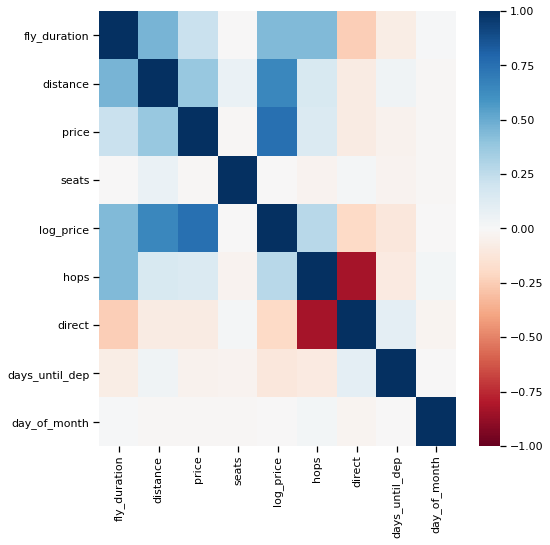

In [62]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);

## Conclusions

1. The main factor in the drop in prices is remaining days until departure.
2. Airfare varies according to the time of departure. It is higher at evenings and cheaper at mornings/nights